Estudio de regiones evanescentes al tener ondas en modo X

In [1]:
#librerías
import numpy as np
import matplotlib.pyplot as plt #gráficos
from scipy import interpolate #interpolación 1
from scipy.interpolate import griddata #interpolación 2
import h5py #archivos en hdf5
from jupyterlab_h5web import H5Web #librería
from pathlib import Path, PurePath #manejo de rutas y archivos
%run -i ./Funciones.py #funciones importante

#Latex y coma como separador decimal
plt.rcParams['text.usetex'] = True #latex
#plt.rc('text', usetex=False)
plt.rcParams['axes.formatter.use_locale'] = True #formato de eje para la coma
#se incluye paquete matematico útil, se corrige el error con el espacio y el espacio entre los números
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \DeclareUnicodeCharacter{202F}{\,} \usepackage{ziffer} \usepackage{siunitx} \sisetup{output-decimal-marker = {,}}') 
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

import locale #líbreria para el formato
locale.setlocale(locale.LC_ALL, "es_CR.utf8")

'es_CR.utf8'

(98, 40, 48)


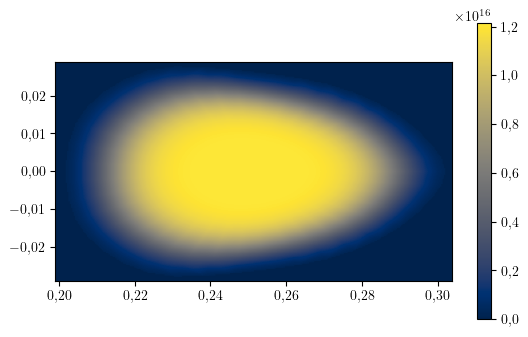

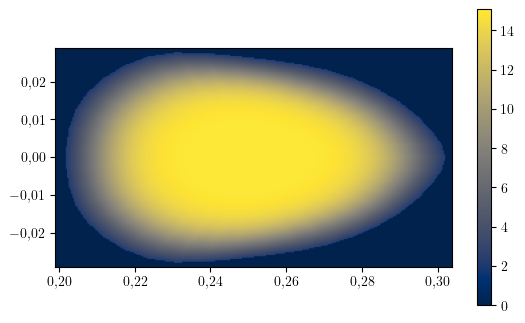

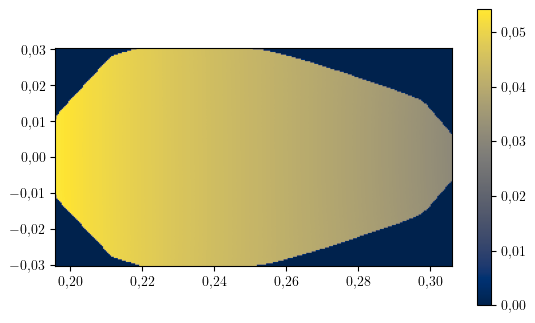

In [19]:
ruta_campo = 'ne_Te_r_z_B/r+z+B_mag_componentes.txt'
ruta_ne = 'ne_Te_r_z_B/densidad.txt'
ruta_Te = 'ne_Te_r_z_B/temperatura.txt'

n_e = np.loadtxt(ruta_ne)
T_e = np.loadtxt(ruta_Te)
r_BS, z_BS, B_x,B_y,B_z = np.loadtxt(ruta_campo, usecols=(0, 1, 2, 3, 4), unpack=True)

r_vmec, z_vmec = variables_vmec('input_VMEC', 'wout_scr_free.nc')
r,z = eliminar_eje_magnetico(r_vmec, z_vmec)
s2DB = campo_magnetico_mapa(r_BS, z_BS)
superficie_2D, ne1, Te1 = densidad_electronica_mapa(r,z,n_e, T_e)
ne_interpol = input_densidad(superficie_2D, ne1)
Te_interpol = input_densidad(superficie_2D, Te1)
B_xint, B_yint, B_zint = input_campo(s2DB, B_x, B_y, B_z)

6.140375029682791


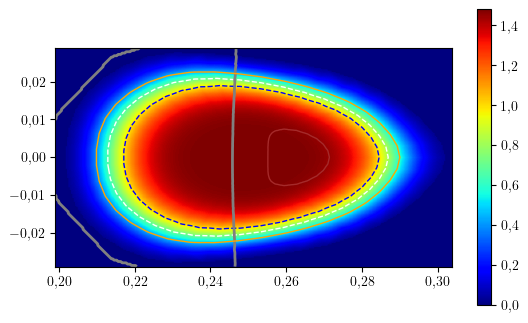

0.286964946051319


In [20]:
from scipy.constants import e, m_e, epsilon_0 #constantes físicas

#Constantes
f_calentamiento = 2.45e9
omega =  2*np.pi*f_calentamiento
n_corte = (m_e*epsilon_0*np.power(omega,2))/(np.power(e,2))

#Factor para un núcleo con un corte muy cerca del núcleo
factor_densidad1 = n_corte/np.max(ne_interpol)
print(factor_densidad1)
factor_densidad = 6.1405*1.48
#factor_densidad = 6.1405*1.75
#factor_densidad = 6.1405*2.14

#campo magnético neto
B_neto = np.sqrt( np.power(B_xint,2) + np.power(B_yint,2) + np.power(B_zint,2) ) 

#Malla
grid_r, grid_z = np.mgrid[0.19893:0.303797:297j, -0.0289025:0.0289019:165j] #cero grados - bsolctra solo 1000

#Frecuencia ciclotrónica electrónica
wce = ((e)/(m_e))*B_neto

#Frecuencia ciclotrónica electrónica normalizada
wec_norm = ((e)/(m_e*omega))*B_neto

#Factor de aumento en segundo armónico multiplicado y sumado
factor_B = 1
wec_norm_1 = ((e)/(m_e*omega))*(factor_B*B_neto)

#Frecuencia del plasma electrónica
wpe = ((factor_densidad*ne_interpol)*np.power(e,2))/(m_e*epsilon_0) #cuadrado de la frecuencia
wpe_norm = np.sqrt( ((factor_densidad*ne_interpol)*np.power(e,2))/(m_e*epsilon_0) )/omega

#Frecuencia híbrida superior normalizada --- Debe coincidir los valores de n_e y B interpolados
wuh_norm = (np.sqrt(np.power(wce,2) + wpe))/omega 

#Densidad electrónica normalizada
ne_norm = (factor_densidad*ne_interpol)/n_corte

#corte R
wR = 0.5 * (wce + np.sqrt((np.power(wce,2) + 4 * wpe)))
wR_norm = wR/omega

#onda L
wL = 0.5 * (-wce + np.sqrt((np.power(wce,2) + 4 * wpe)))
wL_norm = wL/omega

#Gráficos
levels = np.arange(1.0, 1.01, 1) #O mode cut-off
levels1 = np.arange(0.5,0.501, 0.5) # frecuencia de la onda incidente es la mitad de la frecuencia ciclotrónica electrónica
cmap= "jet"

#contour plots
dc = plt.imshow(np.flipud(ne_norm.T), extent=(0.19893,0.303797,-0.0289025,0.0289019), cmap = cmap) #density contour map for matplot lib for python
uh = plt.contour(grid_r,grid_z, wuh_norm, levels, linestyles = 'dashed', colors = 'white', linewidths = 1)
pe = plt.contour(grid_r,grid_z, wpe_norm, levels, linestyles = 'dashed', colors = 'blue', linewidths = 1)
ce = plt.contour(grid_r,grid_z, wec_norm, levels1, linestyles = 'solid', colors = 'gray', linewidths =2)
R = plt.contour(grid_r,grid_z,  wR_norm, levels, linestyles = 'solid', colors = 'orange', linewidths =1)
L = plt.contour(grid_r,grid_z,  wL_norm, levels, linestyles = 'solid', colors = 'brown', linewidths =1)
ac = plt.colorbar(dc, orientation='vertical', shrink=0.8)
plt.gca().set_aspect("equal")
plt.show()

for item in uh.collections:
    for i1 in item.get_paths():
        v1 = i1.vertices
        x1 = v1[:, 0]
        y1 = v1[:, 1]
        print(np.max(x1))

In [21]:
def posicion_uh_ne_con_ne(ne_interpol1, factor_densidad1, fact1, angulo, B_xint1, B_yint1, B_zint1):
    from scipy.constants import e, m_e, epsilon_0 #constantes físicas
    f_calentamiento1 = 2.45e9
    omega1 =  2*np.pi*f_calentamiento1
    #n_corte1 = (m_e*epsilon_0*np.power(omega1,2))/(np.power(e,2))
    
    #campo magnético neto
    B_neto1 = np.sqrt( np.power(B_xint1,2) + np.power(B_yint1,2) + np.power(B_zint1,2) ) 
    wpe1 = ((factor_densidad1*fact1*ne_interpol1)*np.power(e,2))/(m_e*epsilon_0) #cuadrado de la frecuencia
    wpe_norm1 = np.sqrt( ((factor_densidad1*fact1*ne_interpol1)*np.power(e,2))/(m_e*epsilon_0) )/omega1
    wce1 = ((e)/(m_e))*B_neto1
    wuh_norm1 = (np.sqrt(np.power(wce1,2) + wpe1))/omega
    wL1 = 0.5 * (-wce1 + np.sqrt((np.power(wce1,2) + 4 * wpe1)))
    wL_norm1 = wL1/omega1
    #corte R
    wR1 = 0.5 * (wce1 + np.sqrt((np.power(wce1,2) + 4 * wpe1)))
    wR_norm1 = wR1/omega1
    
    grid_r, grid_z = np.mgrid[0.19893:0.303797:297j, -0.0289025:0.0289019:165j]
    levels = np.arange(1.0, 1.01, 1)
    #pe = plt.contour(grid_r,grid_z, wpe_norm1, levels, linestyles = 'dashed', colors = 'blue', linewidths = 1)
    uh = plt.contour(grid_r,grid_z, wuh_norm1, levels, linestyles = 'dashed', colors = 'red', linewidths = 1)
    L = plt.contour(grid_r,grid_z,  wL_norm1, levels, linestyles = 'solid', colors = 'black', linewidths =1)
    R = plt.contour(grid_r,grid_z,  wR_norm1, levels, linestyles = 'solid', colors = 'black', linewidths =1)
    plt.close() #no mostrar el gráfico
    
    for item in R.collections:
        for i1 in item.get_paths():
            v1 = i1.vertices
            x1 = v1[:, 0]
            y1 = v1[:, 1]
            #print(np.max(x1))
    
    for item1 in uh.collections:
        for i11 in item1.get_paths():
            v11 = i11.vertices
            x11 = v11[:, 0]
            y11 = v11[:, 1]
            #print(np.max(x11))
    
    for item11 in L.collections:
        for i111 in item11.get_paths():
            v111 = i111.vertices
            x111 = v111[:, 0]
            y111 = v111[:, 1]
            #print(np.max(x11))
    
    if angulo > 180 and angulo < 360 :
        angulo = angulo - 360       
    
    angulo_R = np.arctan2(-y1, (x1-0.247))
    angulo_uh = np.arctan2(-y11, (x11-0.247))
    angulo_L = np.arctan2(-y111, (x111-0.247))
    index_1 = find_nearest1(angulo_R, np.radians(angulo))
    index_2 = find_nearest1(angulo_uh, np.radians(angulo))
    index_3 = find_nearest1(angulo_L, np.radians(angulo))
    
    return x1[index_1], x11[index_2], x111[index_3], y1[index_1], y11[index_2], y111[index_3]
#factor_densidad = 6.1405
#posicion_uh_ne_con_ne(ne_interpol, factor_densidad, 2, 0.0, B_xint, B_yint, B_zint )

0.09234067899783109
0.07438052876347136
0.057735709834518076
0.05628465687137626
0.05611906965784612
0.05596667363670365
0.04887631433543383


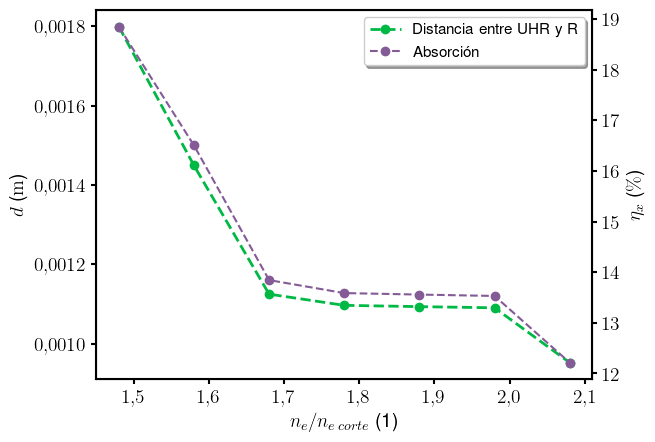

In [22]:
#Posición final de la UHR y corte en modo O dependiendo del factor de densidad
#Pensar mejor el valor del ángulo porque cambia con cada densidad
def plot_final_pos_uh_R(inf, sup, factor_ne, step) :
    from scipy.constants import c #constantes físicas
    aumento_factor_ne = np.arange(inf, sup, step)
    n_filas = aumento_factor_ne.shape[0]
    R_pos_t = np.ndarray((n_filas,), dtype=np.float64)
    uh_pos_t = np.ndarray((n_filas,), dtype=np.float64)
    L_pos_t = np.ndarray((n_filas,), dtype=np.float64)
    eta_ev = np.ndarray((n_filas,), dtype=np.float64)
    f_0 = 2.45e9
    for i in range(n_filas) : 
        fact_final = factor_ne*aumento_factor_ne[i]
        R_posx, uh_posx, L_posx, R_posy, uh_posy, L_posy = posicion_uh_ne_con_ne(ne_interpol, fact_final, aumento_factor_ne[i], 25, B_xint, B_yint, B_zint )
        R_pos_t[i] = np.sqrt(R_posx**2 + R_posy**2) 
        uh_pos_t[i] = np.sqrt(uh_posx**2 + uh_posy**2)
        L_pos_t[i] = np.sqrt(L_posx**2 + L_posy**2)
        coef = (2*np.pi*np.pi*(R_pos_t[i] - uh_pos_t[i])*f_0)/c
        eta_ev[i] = (1 - ( (1-np.exp(-coef))**2 + np.exp(-coef) )  )*100
        print((-uh_pos_t[i]+R_pos_t[i])*(2*np.pi*2.45e9)/(3e8))
    
    
    #Gráfico
    fig = plt.figure()  # create a figure object
    ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure   
    ax.plot(aumento_factor_ne, -uh_pos_t+R_pos_t , '--o', label=r'$\text{Distancia entre UHR y R}$', linewidth=2, color= '#00B945')
    #ax.plot(aumento_factor_ne, R_pos_t, '-', linewidth=2, color= '#0C5DA5', label = 'datos originales') #datos originales
    #ax.plot(aumento_factor_ne, uh_pos_t, '-', linewidth=2, color= '#00B945', label = 'datos originales') #datos originales
    #ax.plot(aumento_factor_ne, L_pos_t, '-', linewidth=2, color= '#845B97', label = 'datos originales') #datos originales
    ax.set_xlabel(r'$ n_{e}/n_{e\,corte} $ (1)', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax.set_ylabel( r'$ d $ (\si{\metre})', 
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax.tick_params(axis='both', labelsize=14, width=1.5) 
    plt.setp(ax.spines.values(), linewidth=1.5)
    
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(aumento_factor_ne, eta_ev, "--o", label=r'$\text{Absorción}$', color='#845B97')
    
    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=11,  ncol=1, fancybox=True, shadow=True)
    ax2.set_ylabel( r'$ \eta_{x} $ (\si{\percent})', 
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax2.tick_params(axis='both', labelsize=14, width=1.5)
    #plt.savefig('dytau_xvsne.png', dpi=300, bbox_inches='tight') 
    plt.show()
plot_final_pos_uh_R(1.48, 2.14, 6.1405, 0.1 )

In [23]:
#Excitation, Propagation, and Damping of Electron Bernstein Waves in Tokamaks
#Identificar ángulo donde está la absorción
def wce_Ln_LB_alfa_uh(ne_interpol1, factor_densidad1, fact1, angulo, B_xint1, B_yint1, B_zint1 ):
    from scipy.constants import e, m_e, epsilon_0, c #constantes físicas
    f_calentamiento1 = 2.45e9
    omega1 =  2*np.pi*f_calentamiento1
    #campo magnético neto
    B_neto1 = np.sqrt( np.power(B_xint1,2) + np.power(B_yint1,2) + np.power(B_zint1,2) ) 
    wpe1 =  ((factor_densidad1*fact1*ne_interpol1)*np.power(e,2))/(m_e*epsilon_0)  #cuadrado de la frecuencia
    wpe_norm1 = np.sqrt( ((factor_densidad1*fact1*ne_interpol1)*np.power(e,2))/(m_e*epsilon_0) )/omega1
    wce1 = ((e)/(m_e))*B_neto1
    wuh1 = (np.sqrt(np.power(wce1,2) + wpe1))
    wuh_norm1 = (np.sqrt(np.power(wce1,2) + wpe1))/omega
    #L_n
    grad_ne_x, grad_ne_y = np.gradient(ne_interpol1*factor_densidad1*fact1)
    grad_ne = np.sqrt(grad_ne_x**2 + grad_ne_y**2)
    L_n = np.abs( ne_interpol1*factor_densidad1*fact1 /(grad_ne) )
    #L_B
    grad_B_x, grad_B_y = np.gradient(B_neto1)
    grad_B = np.sqrt(grad_B_x**2 + grad_B_y**2)
    L_B = np.abs( B_neto1/(grad_B)) 
        
    grid_r, grid_z = np.mgrid[0.19893:0.303797:297j, -0.0289025:0.0289019:165j] 
    pe = plt.contour(grid_r,grid_z, wpe_norm1, levels, linestyles = 'dashed', colors = 'blue', linewidths = 1)
    uh = plt.contour(grid_r,grid_z, wuh_norm1, levels, linestyles = 'dashed', colors = 'red', linewidths = 1)
    plt.close() #no mostrar el gráfico
    
    for item1 in uh.collections:
        for i11 in item1.get_paths():
            v11 = i11.vertices
            x11 = v11[:, 0]
            y11 = v11[:, 1]
            #print(np.max(x11))
    
    if angulo > 180 and angulo < 360 :
        angulo = angulo - 360       
    
    angulo_uh = np.arctan2(-y11, (x11-0.247))
    index = find_nearest1(angulo_uh, np.radians(angulo))
    #print( x11[index], y11[index]) #se encuentran las coordendas espaciales
    r = np.linspace(0.19893, 0.303797, 297)
    z = np.linspace(-0.0289025, 0.0289019, 165)
    indice_r = find_nearest1(r, x11[index]) #se buscan las coordenadas con las dimensiones
    indice_z = find_nearest1(z, y11[index])
    
    #variable para el parámetro de Budden
    alpha = np.sqrt( wpe1[indice_r,indice_z] )/wce1[indice_r,indice_z]
    wce_uhr = wce1[indice_r,indice_z]
    L_n_uhr = L_n[indice_r,indice_z]
    L_B_uhr = L_B[indice_r,indice_z]
    
    #Parámetro de budden
    frac_1 = (wce_uhr*L_n_uhr)/c
    frac_2 = L_n_uhr/L_B_uhr
    frac_3 = alpha/(np.sqrt(alpha**2 + 2*(frac_2) ))
    frac_4 = (np.sqrt(1+alpha**2)-1)/(alpha**2+(frac_2*(np.sqrt(1+alpha**2)) ) )
    eta = frac_1*frac_3*np.power(frac_4,0.5)
    
    #Transmitancia
    #print('El parámetro de budden es', eta)
    #print('La transmitancia de SX a FX es', np.exp(-np.pi*eta))
    lambda_01 = c/f_calentamiento1
    k_01 = (2*np.pi)/(lambda_01)
    #print(k_01*L_n[10:-20,82])
    print(k_01*L_n_uhr)
    
    return eta, alpha
factor_densidad = 6.1405
wce_Ln_LB_alfa_uh(ne_interpol, factor_densidad, 10.14, 18, B_xint, B_yint, B_zint )

324.36851178254415


/tmp/ipykernel_106226/3505671171.py:17: RuntimeWarning: divide by zero encountered in true_divide
  L_n = np.abs( ne_interpol1*factor_densidad1*fact1 /(grad_ne) )
/tmp/ipykernel_106226/3505671171.py:17: RuntimeWarning: invalid value encountered in true_divide
  L_n = np.abs( ne_interpol1*factor_densidad1*fact1 /(grad_ne) )
/tmp/ipykernel_106226/3505671171.py:21: RuntimeWarning: invalid value encountered in true_divide
  L_B = np.abs( B_neto1/(grad_B))


(69.24545578202482, 2.3727082138350784)

/tmp/ipykernel_106226/3505671171.py:17: RuntimeWarning: divide by zero encountered in true_divide
  L_n = np.abs( ne_interpol1*factor_densidad1*fact1 /(grad_ne) )
/tmp/ipykernel_106226/3505671171.py:17: RuntimeWarning: invalid value encountered in true_divide
  L_n = np.abs( ne_interpol1*factor_densidad1*fact1 /(grad_ne) )
/tmp/ipykernel_106226/3505671171.py:21: RuntimeWarning: invalid value encountered in true_divide
  L_B = np.abs( B_neto1/(grad_B))


1133.5632914023656
51.312680008633286
2.151524146845213
1038.061014662263
51.312680008633286
2.1557086091909468
919.1559646408027
51.312680008633286
2.112036108277893
926.2841318376209
51.312680008633286
2.1888132936908673
844.3549529502139
51.312680008633286
2.1651346949465973
813.3324010532185
51.312680008633286
2.1840740896775888
749.018110889527
51.312680008633286
2.1424672648085337


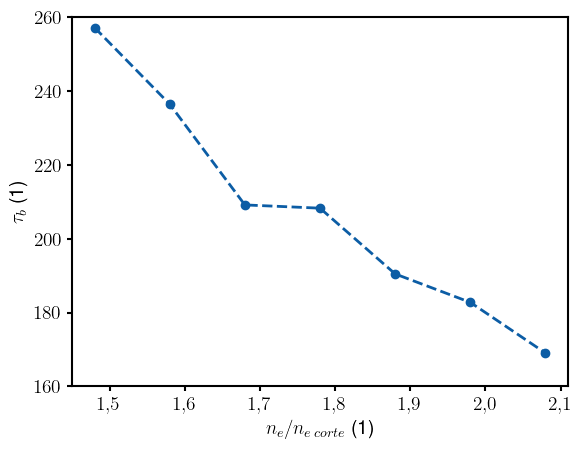

In [24]:
def plot_sxfx(ne_inicial, factor_ne, inicio, final, angulo, Bx, By, Bz):
    aumento_factor_ne = np.arange(inicio, final, 0.1) #matriz con densidades
    n_filas = aumento_factor_ne.shape[0] #numero de elementos
    buddensxfx = np.ndarray((n_filas,), dtype=np.float64) #matriz para almacenar
    L_ne = np.ndarray((n_filas,), dtype=np.float64)
    
    for i in range(n_filas) :
        eta_b, Lne = wce_Ln_LB_alfa_uh(ne_inicial, factor_ne, aumento_factor_ne[i], angulo, Bx, By, Bz)
        buddensxfx[i] = eta_b
        L_ne[i] = Lne
        print((2*np.pi*2.45e9/3e8))
        print(L_ne[i])
    fig = plt.figure()  # create a figure object
    ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure   
    ax.plot(aumento_factor_ne, buddensxfx, '--o', label=r'$\text{Distancia entre UHR y R}$', linewidth=2, color= '#0C5DA5')
    ax.set_xlabel(r'$ n_{e}/n_{e\,corte} $ (1)', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax.set_ylabel( r'$ \tau_{b} $ (1)', 
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax.tick_params(axis='both', labelsize=14, width=1.5) 
    plt.setp(ax.spines.values(), linewidth=1.5)
    ax.set_ylim(160,260)
    #plt.savefig('tau_bvsne.png', dpi=300, bbox_inches='tight')
    plt.show()
plot_sxfx(ne_interpol, 6.1405, 1.48, 2.14, 17, B_xint, B_yint, B_zint )